# 「データ解析のための統計モデリング入門(緑本) 11章」補足用ノート
<div style="text-align: right;">
2019/10/18<br>   
AI研C 1S 大澤
</div>

"データ解析のための統計モデリング入門―― 一般化線形モデル・階層ベイズモデル・MCMC"の11章の補足用ノートになります<br>
MCMCのライブラリとしてPyMC3を使っています．Stanではないのでご注意ください．

In [1]:
import numpy as np
import pandas as pd

#import pystan
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

import seaborn as sns

from pymc3.distributions import continuous
from pymc3.distributions import distribution
import scipy.stats as stats
import pymc3 as pm
from theano import shared
import theano
import theano.tensor as tt

# データを読み込んで要約する
file = 'data/c11/d.csv'
csv_df = pd.read_csv(file)
print(csv_df.head(10))

csv_df.describe()

    y          m
0   0   2.154980
1   3   3.254165
2   2   4.628666
3   5   6.234124
4   6   7.990730
5  16   9.794474
6   8  11.533365
7  14  13.104252
8  11  14.426302
9  10  15.448779


,y,m
count,50.000000,50.000000
mean,10.880000,10.990589
std,5.231927,3.865481
min,0.000000,2.154980
25%,7.000000,9.804759
50%,11.000000,11.573849
75%,15.000000,13.101365
max,19.000000,16.662963


## 1.データの描画

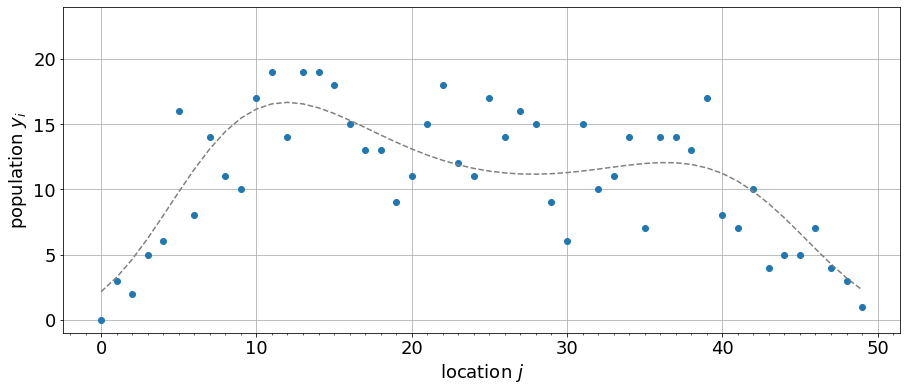

In [2]:
y_df = csv_df['y']
m_df = csv_df['m']

y_list = csv_df['y'].values # 

x_range = len(csv_df)
xx = np.arange(x_range)
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
#plt.scatter(xx, y_df, s=100)
plt.plot(range(len(y_list)),y_list, 'o')
plt.plot(xx, m_df, color="0.5",linestyle="dashed")
plt.xlabel('location $j$')
plt.ylabel('population $y_i$')
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid() #plt.grid(which='minor')
plt.ylim(-1, 24)
plt.show()

## 2.空間構造のある階層事前分布
CARモデルの作成にはPYMCのドキュメントを参考にした<br>
https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

In [3]:
# 上の公式ドキュメント(？)から採用
class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : adjacency matrix
    w : weight matrix
    tau : precision at each location
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a

        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [4]:
# 隣の情報．これを作らないとだめらしい
adj = np.array(
       [[1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9],
       [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15], [14, 16],
       [15, 17], [16, 18], [17, 19], [18, 20], [19, 21], [20, 22],
       [21, 23], [22, 24], [23, 25], [24, 26], [25, 27], [26, 28],
       [27, 29], [28, 30], [29, 31], [30, 32], [31, 33], [32, 34],
       [33, 35], [34, 36], [35, 37], [36, 38], [37, 39], [38, 40],
       [39, 41], [40, 42], [41, 43], [42, 44], [43, 45], [44, 46],
       [45, 47], [46, 48], [47, 49], [49]], dtype=object)

# 重み．全部同じ
weights = np.array(
       [[1.0], [1, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0]], dtype=object)

N = len(weights)
wmat2 = np.zeros((N,N))
amat2 = np.zeros((N,N))
for i, a in enumerate(adj):
    amat2[i,a] = 1
    wmat2[i,a] = weights[i]


In [5]:
# モデルを作って計算
with pm.Model() as spc_model: # spatial correlationにした
    
    # 固定効果
    beta = pm.Normal('beta', mu=0, sd=1000)
    # hyper parameterの設定
    s = pm.Uniform('s', lower=0, upper=100) # def100
    #s = pm.Normal('s', mu=0, sd=1000)
    
    # tauは分散の逆数
    tau = 1/(s*s)
    
    # ランダム効果
    r =CAR2('r', w=wmat2, a=amat2, tau=tau, shape=N)
    # 出力はPoisson分布
    y = pm.Poisson('y', mu=np.exp(beta + r[np.arange(50)]), observed=y_list)
    
    inference = pm.ADVI()
    approx = pm.fit(n=100000, method=inference,random_seed=123, start=pm.find_MAP(method='Powell'))
    trace = approx.sample(draws=5000)

D:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]D:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:500: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -33.658, ||grad|| = 50.931: : 5001it [00:01, 3411.07it/s]                                                       

Average Loss = 148.63: 100%|█████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3284.21it/s]
Finished [100%]: Average Loss = 148.63


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021D35BB2908>,
      dtype=object)

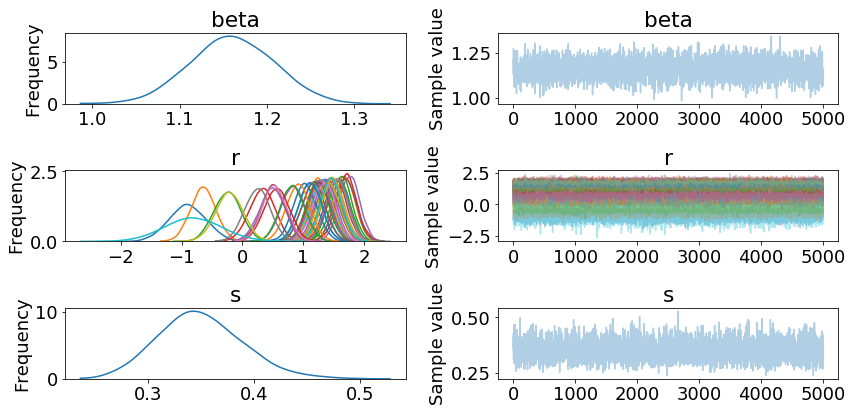

In [7]:
pm.traceplot(trace)

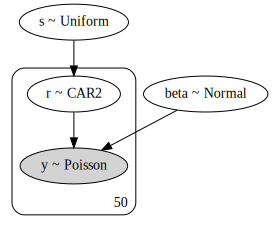

In [8]:
# グラフィカルモデル
pm.model_to_graphviz(spc_model)

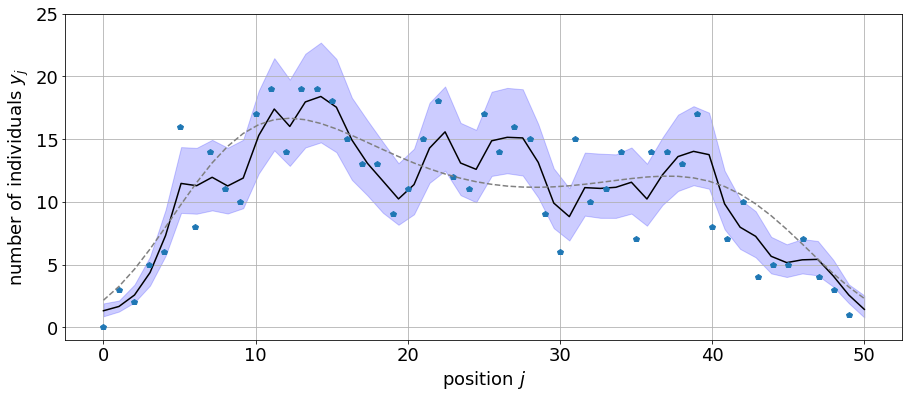

In [6]:
# 描画
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
b = np.median(trace.get_values('beta'))
r = np.median(trace.get_values('r'),axis=0)
xx = np.linspace(0, len(csv_df), len(csv_df))
yy = np.exp(b+r)
plt.plot(xx,yy, 'k-')
hpd = pm.hpd(trace.get_values('r'), alpha=0.20)
plt.fill_between(xx, np.exp(b+hpd.T[0]), np.exp(b+hpd.T[1]), color='blue', alpha=0.2)
plt.plot(range(len(y_list)),y_list, 'p')
plt.plot(xx, m_df, color="0.5",linestyle="dashed")
plt.xlabel('position $j$')
plt.ylabel('number of individuals $y_j$')
plt.ylim(-1, 25)
plt.grid()
#plt.show()

In [7]:
with pm.Model() as spc_model: # spatial correlationにした
    
    # 固定効果
    beta = pm.Normal('beta', mu=0, sd=1000)
    
    # ランダム効果
    r =pm.Normal('r', mu=0, sd=1, shape=50)
    # 出力はPoisson分布
    y = pm.Poisson('y', mu=np.exp(beta + r[np.arange(50)]), observed=y_list)
    
    inference = pm.ADVI()
    approx = pm.fit(n=100000, method=inference,random_seed=123, start=pm.find_MAP(method='Powell'))
    trace = approx.sample(draws=5000)

D:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]D:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:500: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -247.99, ||grad|| = 24.969: 100%|█████████████████████████████████████████| 2200/2200 [00:00<00:00, 3869.97it/s]
Average Loss = 182.26: 100%|█████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4007.10it/s]
Finished [100%]: Average Loss = 182.27


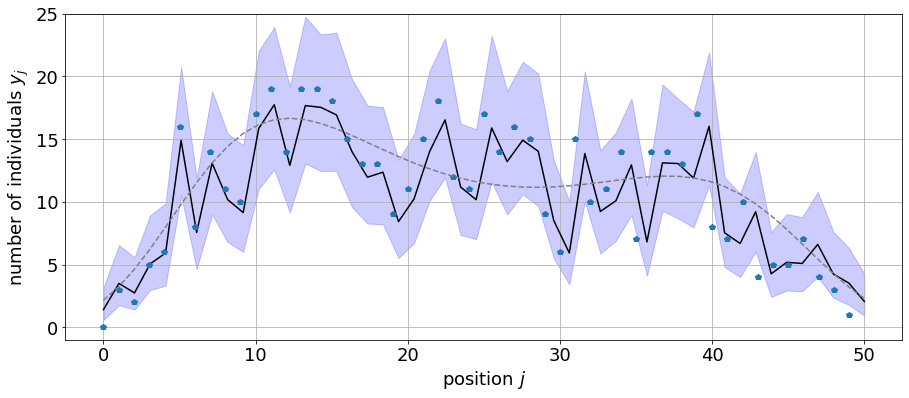

In [8]:
# 描画
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
b = np.median(trace.get_values('beta'))
r = np.median(trace.get_values('r'),axis=0)
xx = np.linspace(0, len(csv_df), len(csv_df))
yy = np.exp(b+r)
plt.plot(xx,yy, 'k-')
hpd = pm.hpd(trace.get_values('r'), alpha=0.20)
plt.fill_between(xx, np.exp(b+hpd.T[0]), np.exp(b+hpd.T[1]), color='blue', alpha=0.2)
plt.plot(range(len(y_list)),y_list, 'p')
plt.plot(xx, m_df, color="0.5",linestyle="dashed")
plt.xlabel('position $j$')
plt.ylabel('number of individuals $y_j$')
plt.ylim(-1, 25)
plt.grid()
#plt.show()

## 3.空間統計が作り出す確率場
sの値を変化させたときに，推定値はどう変化するか

logp = -4.2243, ||grad|| = 80.33: : 5001it [00:01, 4199.64it/s]                                                        

Average Loss = 139.76: 100%|█████████████████████████████████████████████████| 100000/100000 [00:23<00:00, 4183.05it/s]
Finished [100%]: Average Loss = 139.78
logp = -83.235, ||grad|| = 54.189: : 5001it [00:01, 4267.55it/s]                                                       

Average Loss = 129.73: 100%|█████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4109.13it/s]
Finished [100%]: Average Loss = 129.73
logp = -245.51, ||grad|| = 0.039665: 100%|███████████████████████████████████████| 1106/1106 [00:00<00:00, 4453.64it/s]
Average Loss = 257.14:  79%|███████████████████████████████████████▋          | 79352/100000 [00:18<00:04, 4927.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg

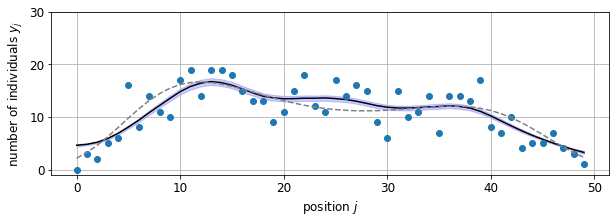

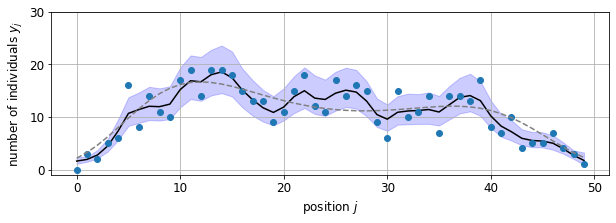

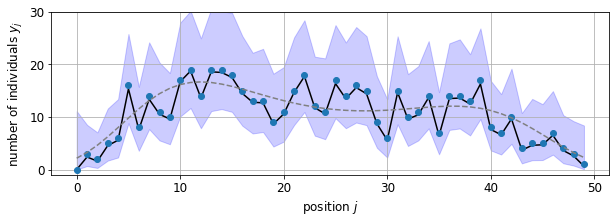

In [7]:
result_list=[]
for i in range(3):
    s_list = [0.0316,0.224,10]
    with pm.Model() as spc_model: # spatial correlationにした

        # 固定効果
        beta = 2.27#pm.Normal('beta', mu=0, sd=1000)
        # hyper parameterの設定
        #s = pm.Uniform('s', lower=0, upper=100) # def100
        s = s_list[i] #pm.Normal('s', mu=0, sd=1000)

        # tauは分散の逆数（精度行列）
        tau = 1/(s*s)

        # ランダム効果
        r =CAR2('r', w=wmat2, a=amat2, tau=tau, shape=N)
        # 出力はPoisson分布
        y = pm.Poisson('y', mu=np.exp(beta + r[np.arange(50)]), observed=y_list)

        inference = pm.ADVI()
        approx = pm.fit(n=100000, method=inference,random_seed=123, start=pm.find_MAP(method='Powell'))
        trace = approx.sample(draws=5000)

    plt.figure(figsize=(10,3))
    plt.rcParams["font.size"] = 12
    b = beta#np.median(trace.get_values('beta'))
    r = np.median(trace.get_values('r'),axis=0)
    #xx = np.linspace(1, len(csv_df), len(csv_df))
    yy = np.exp(b+r)
    plt.plot(xx,yy, 'k-')
    hpd = pm.hpd(trace.get_values('r'), alpha=0.05)
    plt.fill_between(xx, np.exp(b+hpd.T[0]), np.exp(b+hpd.T[1]), color='blue', alpha=0.2)
    plt.plot(range(len(y_list)),y_list, 'o')
    plt.plot(xx, m_df, color="0.5",linestyle="dashed")
    plt.xlabel('position $j$')
    plt.ylabel('number of individuals $y_j$')
    plt.ylim(-1, 30)
    plt.grid()
    #plt.show()
    #result_list[i]=trace.get_values('r')

In [ ]:
for i in renge(3):
    print(i)
    

## 4.欠損のある観測データ
欠損データに関して，空間的な関係を考慮したモデルは良い性質を示す

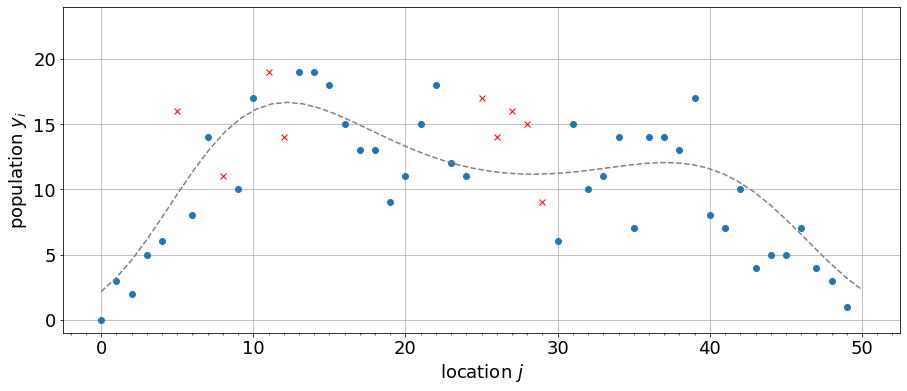

In [11]:
delete_list = [5,8,11,12,25,26,27,28,29]  # 欠損させる
leave_list = list(set(range(len(csv_df))) - set(delete_list) ) # 残す
#print(leave_list)


# 欠損したデータリスト作成
y_df = csv_df['y'].astype(float)
for i in delete_list:
    #print(csv_df.iat[i, 0])
    y_df.iat[i] = np.nan
y1_list = y_df.values

# 残すデータリスト作成
y_df = csv_df['y'].astype(float)
for i in leave_list:
    y_df.iat[i] = np.nan
y2_list = y_df.values

#x_range = len(csv_df)
#xx = np.arange(x_range)
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
#plt.scatter(xx, y_df, s=100)
plt.plot(range(len(y_list)),y1_list, 'o')
plt.plot(range(len(y_list)),y2_list, 'x', color="r")
plt.plot(xx, m_df, color="0.5",linestyle="dashed")
plt.xlabel('location $j$')
plt.ylabel('population $y_i$')
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid() #plt.grid(which='minor')
plt.ylim(-1, 24)
plt.show()

青い丸が欠損せずに残ったデータ<br>
赤いバツば欠損したデータ．一応教科書を再現した．

In [12]:
with pm.Model() as spc_model: # spatial correlationにした
    
    # 固定効果
    beta = pm.Normal('beta', mu=0, sd=1000)
    # hyper parameterの設定
    s = pm.Normal('s', mu=0, sd=1000)
    
    # tauは分散の逆数
    tau = 1/(s*s)
    
    # ランダム効果
    r =CAR2('r', w=wmat2, a=amat2, tau=tau, shape=N)
    # 出力はPoisson分布
    y = pm.Poisson('y', mu=np.exp(beta + r[np.arange(50)]), observed=y1_list)
    
    inference = pm.ADVI()
    approx = pm.fit(n=100000, method=inference,random_seed=123, start=pm.find_MAP(method='Powell'))
    trace = approx.sample(draws=5000)

  0%|                                                 | 0/5000 [00:00<?, ?it/s] G:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:500: RuntimeWarning:Method Powell does not use gradient information (jac).
logp = -inf, ||grad|| = 5,558.2: 100%|█████| 626/626 [00:00<00:00, 3125.32it/s]
Average Loss = inf: 100%|████████████| 100000/100000 [00:36<00:00, 2769.23it/s]
Finished [100%]: Average Loss = nan


#### 空間的な関係を考慮したモデル

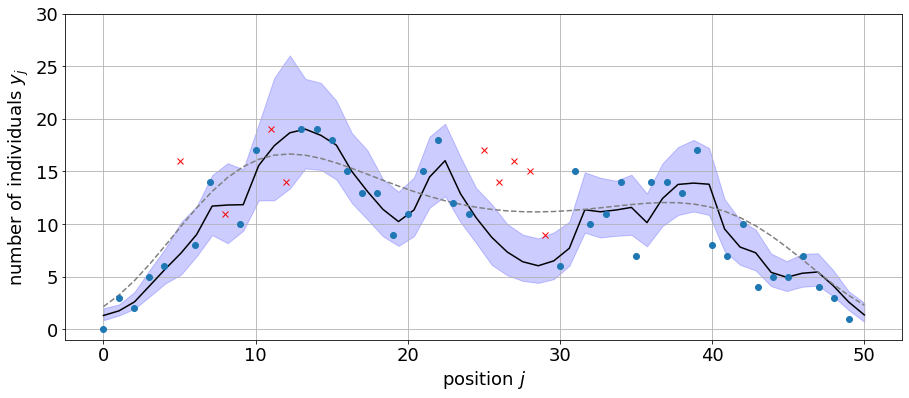

In [13]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
b = np.median(trace.get_values('beta'))
r = np.median(trace.get_values('r'),axis=0)
#xx = np.linspace(1, len(csv_df), len(csv_df))
yy = np.exp(b+r)
plt.plot(xx,yy, 'k-')
hpd = pm.hpd(trace.get_values('r'), alpha=0.20)
plt.fill_between(xx, np.exp(b+hpd.T[0]), np.exp(b+hpd.T[1]), color='blue', alpha=0.2)
plt.plot(xx, m_df, color="0.5",linestyle="dashed")
plt.plot(range(len(y_list)),y1_list, 'o')
plt.plot(range(len(y_list)),y2_list, 'x', color="r")
plt.xlabel('position $j$')
plt.ylabel('number of individuals $y_j$')
plt.ylim(-1, 30)
plt.grid()

↑空間的な関係を考慮したモデルでも欠損部分の推定区間が大きくなる

#### 空間的な関係を考慮していないモデル

In [14]:
with pm.Model() as spc_model: # spatial correlationにした
    
    # 固定効果
    beta = pm.Normal('beta', mu=0, sd=1000)
    
    # ランダム効果
    r =pm.Normal('r', mu=0, sd=1, shape=50)
    # 出力はPoisson分布
    y = pm.Poisson('y', mu=np.exp(beta + r[np.arange(50)]), observed=y1_list)
    
    inference = pm.ADVI()
    approx = pm.fit(n=100000, method=inference,random_seed=123, start=pm.find_MAP(method='Powell'))
    trace = approx.sample(draws=5000)

 G:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  0%|                                                 | 0/5000 [00:00<?, ?it/s] G:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:500: RuntimeWarning:Method Powell does not use gradient information (jac).
logp = -inf, ||grad|| = 6,499.4: 100%|█████| 614/614 [00:00<00:00, 3233.62it/s]
Average Loss = inf: 100%|████████████| 100000/100000 [00:34<00:00, 2903.08it/s]
Finished [100%]: Average Loss = nan


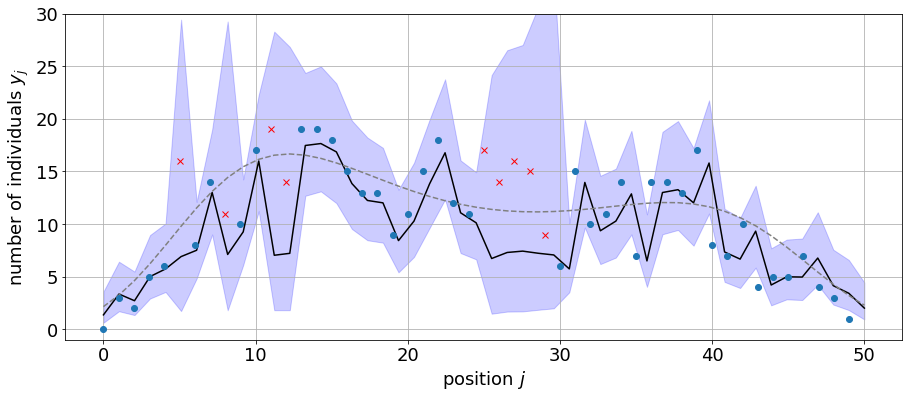

In [15]:
#print(trace)
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
b = np.median(trace.get_values('beta'))
r = np.median(trace.get_values('r'),axis=0)
xx = np.linspace(0, len(csv_df), len(csv_df))
yy = np.exp(b+r)
plt.plot(xx,yy, 'k-')
hpd = pm.hpd(trace.get_values('r'), alpha=0.2)
plt.fill_between(xx, np.exp(b+hpd.T[0]), np.exp(b+hpd.T[1]), color='blue', alpha=0.2)
plt.plot(xx, m_df, color="0.5",linestyle="dashed")
plt.plot(range(len(y_list)),y1_list, 'o')
plt.plot(range(len(y_list)),y2_list, 'x', color="r")
plt.xlabel('position $j$')
plt.ylabel('number of individuals $y_j$')
plt.ylim(-1, 30)
plt.grid()

↑空間的な関係を考慮していないモデル．欠損値のところで推定区間が大きくなった．これも教科書と同じにはならないけど，傾向が見られたのでまあいいや

## 5.ガウシアンプロセスによる回帰
PYMCでも出来ますが，少々大変なのでGPyを使いました

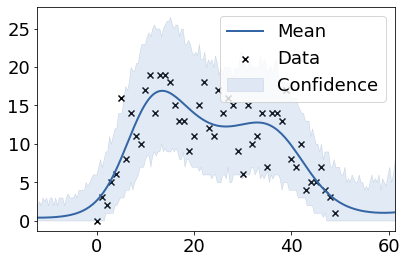

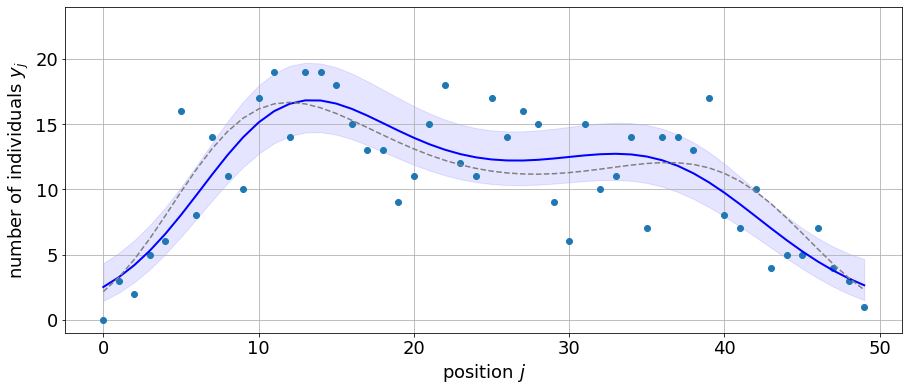

In [3]:
import GPy

kernel = GPy.kern.RBF(1)

xxx = xx[:, None] # 縦ベクトルにしないと駄目
#print(xxx)
model = GPy.core.GP(X=xxx, Y=y_df[:,None], kernel=kernel,
    inference_method=GPy.inference.latent_function_inference.Laplace(),
    likelihood=GPy.likelihoods.Poisson()) # ポアソン分布
model.optimize()
model.plot()

f_mean, f_var = model._raw_predict(xxx)
f_upper, f_lower = f_mean + 2*np.sqrt(f_var), f_mean - 2.*np.sqrt(f_var)

# 描画
plt.figure(figsize=(15,6))
plt.plot(range(len(y_list)),y_list, 'o')
plt.plot(xxx, np.exp(f_mean), color='blue', lw=2)
plt.fill_between(xx, np.exp(f_lower[:,0]), np.exp(f_upper[:,0]), color='blue', alpha=.1)
plt.plot(xx, m_df, color="0.5",linestyle="dashed")
plt.xlabel('position $j$')
plt.ylabel('number of individuals $y_j$')
plt.ylim(-1, 24)
plt.grid()
plt.show()